# Whale Identification
* Minibatch Generator
* Data Augmentation
* VGG
* Train
* Test

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator

/Users/rajkirangaddati/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using plaidml.keras.backend backend.


In [2]:
import pandas as pd

In [3]:
train_labels=pd.read_csv('../../train.csv',engine='c')

In [4]:
train_labels.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [17]:
from multiprocessing.pool import Pool
import os

In [20]:
def createClassFolders(classId):
    os.mkdir('../../train/'+classId)

In [22]:
with Pool(4) as p:
    p.map(createClassFolders, train_labels.Id.unique())

In [29]:
import shutil
def moveImagesToClassDir(row):
    image=row[0]
    classId=row[1]
    shutil.move('../../train/'+image, '../../train/'+classId+'/'+image)

In [26]:
train_labels.values[0][1]

'w_f48451c'

In [30]:
with Pool(4) as p:
    p.map(moveImagesToClassDir, train_labels.values)

In [5]:
trainGen=ImageDataGenerator(featurewise_center=False, 
                    samplewise_center=False, 
                     featurewise_std_normalization=False, 
                     samplewise_std_normalization=False, 
                     zca_whitening=False, 
                     zca_epsilon=1e-06, 
                     rotation_range=0, 
                     width_shift_range=10, 
                     height_shift_range=10, 
                     brightness_range=None, 
                     shear_range=0.0, 
                     zoom_range=0.0, 
                     channel_shift_range=0.1, 
                     fill_mode='nearest', 
                     cval=0.0, 
                     horizontal_flip=True, 
                     vertical_flip=False, 
                     rescale=None, 
                     preprocessing_function=None, 
                     data_format=None, 
                     validation_split=0.3)


In [24]:
train_generator = trainGen.flow_from_directory(
        '../../train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 25361 images belonging to 5005 classes.


In [40]:
next(train_generator)[0][0].shape

(150, 150, 3)

In [45]:
train_generator.class_indices['new_whale']

0

In [11]:
%matplotlib inline

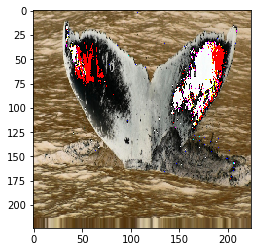

In [51]:
import scipy.ndimage
plt.imshow(next(train_generator)[0][0])

In [8]:
train_generator.image_shape

(150, 150, 3)

In [54]:
mdl=keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=5005)

58892288/58889256 [==============================] - 7s 0us/step

In [36]:
mdl.layers

In [61]:
for i in mdl.layers:
    print(i.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [69]:
mdl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [62]:
mdl.layers[-1].get_config()

{'data_format': 'channels_last',
 'name': 'block5_pool',
 'padding': 'valid',
 'pool_size': (2, 2),
 'strides': (2, 2),
 'trainable': True}

In [56]:
from keras.optimizers import SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
mdl.compile(optimizer=sgd, loss='categorical_crossentropy')

In [65]:
?? mdl.layers.append()

In [57]:
mdl.fit_generator(train_generator,
                    steps_per_epoch=10000, epochs=10)

Epoch 1/10


ValueError: Error when checking target: expected block5_pool to have 4 dimensions, but got array with shape (32, 5005)

In [32]:
x.get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'fc2',
 'trainable': True,
 'units': 4096,
 'use_bias': True}

In [20]:
?? plot_model

In [66]:
from keras.utils.vis_utils import plot_model
plot_model(mdl,to_file='vgg.png')

In [67]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

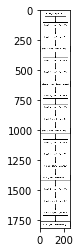

In [68]:
plt.imshow(mpimg.imread('vgg.png'))

In [9]:
import plaidml
plaidml.__version__

'0.3.5'

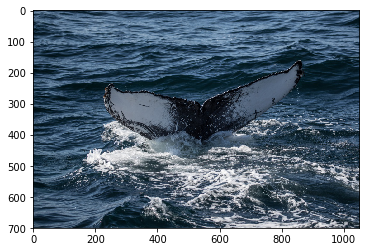

In [10]:
%matplotlib inline
img=mpimg.imread('../../train/0000e88ab.jpg')
plt.imshow(img)

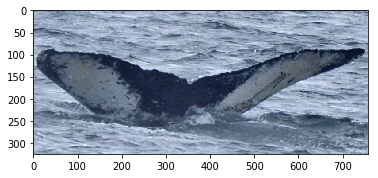

In [11]:
%matplotlib inline
img=mpimg.imread('../../train/0001f9222.jpg')
plt.imshow(img)

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, path, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load(path + list_IDs_temp)

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)